In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/home-credit-default-risk/bureau_balance.csv
/kaggle/input/home-credit-default-risk/credit_card_balance.csv
/kaggle/input/home-credit-default-risk/previous_application.csv
/kaggle/input/home-credit-default-risk/application_test.csv
/kaggle/input/home-credit-default-risk/installments_payments.csv
/kaggle/input/home-credit-default-risk/bureau.csv
/kaggle/input/home-credit-default-risk/HomeCredit_columns_description.csv
/kaggle/input/home-credit-default-risk/POS_CASH_balance.csv
/kaggle/input/home-credit-default-risk/sample_submission.csv
/kaggle/input/home-credit-default-risk/application_train.csv


In [2]:
# загружаем данные
app_train = pd.read_csv('/kaggle/input/home-credit-default-risk/application_train.csv')
app_test = pd.read_csv('/kaggle/input/home-credit-default-risk/application_test.csv')
sample_submission = pd.read_csv('/kaggle/input/home-credit-default-risk/sample_submission.csv')

## Шаг 1. Начнём

Традиционный простейший прогон изучаемого алгоритма. Убедимся, что работает.
Для этого возьмём пару понятных и проверенных фичей и посмотрим, что нам покажет кросс-валидация

In [3]:
features = ['AMT_INCOME_TOTAL','AMT_CREDIT']

In [8]:
from lightgbm import LGBMClassifier
from sklearn.model_selection import cross_val_score

In [5]:
boost_model = LGBMClassifier()

In [10]:
crosval = cross_val_score(boost_model, app_train[features],  y = app_train['TARGET'],
                          cv = 5, scoring= 'roc_auc')
print("boost_model:",max(crosval), min(crosval))
print(crosval)
print("mean = ", np.mean(crosval))
# ого средний roc_auc = 0.590 неплохо для двух фичей и дефолтных гиперпараметров

tree_model: 0.5974515299836483 0.5847401663244316
[0.59745153 0.58474017 0.58762887 0.58917442 0.59116648]
mean =  0.5900322934814737


## Шаг 2. Добавим фичей
Использую те же, что в прошлый раз

In [11]:
# Заполняем пропуски в сэмплах
mean = app_train['AMT_GOODS_PRICE'].mean()
app_train['AMT_GOODS_PRICE'] = app_train['AMT_GOODS_PRICE'].fillna(mean)

mean = app_train['AMT_ANNUITY'].mean()
app_train['AMT_ANNUITY'] = app_train['AMT_ANNUITY'].fillna(mean)

mean = app_train['EXT_SOURCE_2'].mean()
app_train['EXT_SOURCE_2'] = app_train['EXT_SOURCE_2'].fillna(mean)

In [13]:
# Feature encoding
from sklearn import preprocessing

for col in ['FLAG_OWN_CAR', 'FLAG_OWN_REALTY']:
    le = preprocessing.LabelEncoder()
    le.fit(app_train[col])
    app_train[col] = le.transform(app_train[col])
    app_test[col] = le.transform(app_test[col])

In [53]:
features = ['AMT_INCOME_TOTAL','AMT_CREDIT','AMT_ANNUITY','AMT_GOODS_PRICE','FLAG_OWN_CAR',
            'FLAG_OWN_REALTY', 'DAYS_BIRTH', 'DAYS_EMPLOYED','EXT_SOURCE_2']

In [54]:
for i in range(3, len(features)+1):
    crosval = cross_val_score(boost_model, app_train[features[:i]],  y = app_train['TARGET'], cv = 5, scoring= 'roc_auc')
    print("#boost_model mean = ", np.mean(crosval)," i = ",i)

#boost_model mean =  0.5232814979908583  i =  1
#boost_model mean =  0.5900322934814737  i =  2
#boost_model mean =  0.6289444887262194  i =  3
#boost_model mean =  0.6408017865486734  i =  4
#boost_model mean =  0.6408386944361397  i =  5
#boost_model mean =  0.6411866100556238  i =  6
#boost_model mean =  0.6501014137287646  i =  7
#boost_model mean =  0.657410713981616  i =  8
#boost_model mean =  0.7033031168491359  i =  9

# Видно, что ['FLAG_OWN_CAR','FLAG_OWN_REALTY'] мало влияют

#boost_model mean =  0.6289444887262194  i =  3
#boost_model mean =  0.6408017865486734  i =  4
#boost_model mean =  0.6408386944361397  i =  5
#boost_model mean =  0.6411866100556238  i =  6
#boost_model mean =  0.6501014137287646  i =  7
#boost_model mean =  0.657410713981616  i =  8
#boost_model mean =  0.7033031168491359  i =  9


# Шаг 3. Исследуем гиперпараметры бустинга

In [58]:
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from sklearn.metrics import roc_auc_score

In [56]:
#делим train на тестовую и тренировочную части
X_train, X_test, y_train, y_test = train_test_split(
    app_train, app_train['TARGET'], test_size=0.33, random_state=2020)

#### 1. Варьируем гиперпараметр "Максимальная глубина решающего дерева"

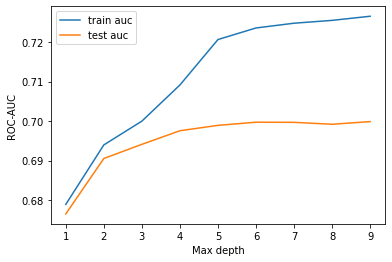

In [80]:
# max_depth
auc_train_list = []
auc_test_list = []

for m_depth in range(1,10):
    boost_model = LGBMClassifier(random_state=2020, max_depth = m_depth, n_estimators = 50)
    boost_model.fit(X_train[features], y_train)
    predict_test = boost_model.predict_proba(X_test[features])[:,1]
    predict_train = boost_model.predict_proba(X_train[features])[:,1]
    
    auc_test = roc_auc_score(y_test, predict_test)
    auc_train = roc_auc_score(y_train, predict_train)
    
    auc_train_list.append(auc_train)
    auc_test_list.append(auc_test)
    
plt.plot(range(1,10), auc_train_list, label = 'train auc')
plt.plot(range(1,10), auc_test_list, label = 'test auc')
plt.xlabel('Max depth')
plt.ylabel('ROC-AUC')
plt.legend()
plt.show()

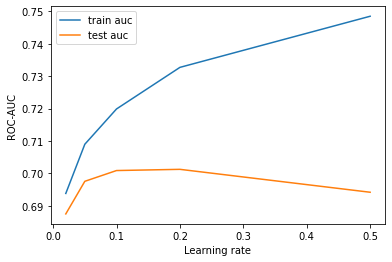

In [66]:
# learning rate
auc_train_list = []
auc_test_list = []

l_rates = [0.02,0.05,0.1,0.2,0.5]

for rate in l_rates:
    boost_model = LGBMClassifier(random_state=2020, learning_rate = rate, max_depth = 4)
    boost_model.fit(X_train[features], y_train)
    predict_test = boost_model.predict_proba(X_test[features])[:,1]
    predict_train = boost_model.predict_proba(X_train[features])[:,1]
    
    auc_test = roc_auc_score(y_test, predict_test)
    auc_train = roc_auc_score(y_train, predict_train)
    
    auc_train_list.append(auc_train)
    auc_test_list.append(auc_test)
    
plt.plot(l_rates, auc_train_list, label = 'train auc')
plt.plot(l_rates, auc_test_list, label = 'test auc')
plt.xlabel('Learning rate')
plt.ylabel('ROC-AUC')
plt.legend()
plt.show()

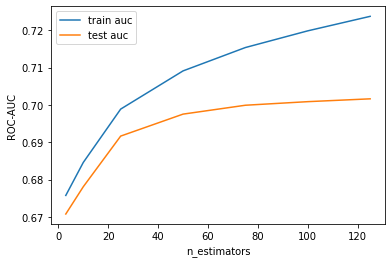

In [71]:
# n_estimators
auc_train_list = []
auc_test_list = []

estimators = [3,10,25,50,75,100,125]

for n in estimators:
    boost_model = LGBMClassifier(random_state=2020, n_estimators = n, max_depth = 4)
    boost_model.fit(X_train[features], y_train)
    predict_test = boost_model.predict_proba(X_test[features])[:,1]
    predict_train = boost_model.predict_proba(X_train[features])[:,1]
    
    auc_test = roc_auc_score(y_test, predict_test)
    auc_train = roc_auc_score(y_train, predict_train)
    
    auc_train_list.append(auc_train)
    auc_test_list.append(auc_test)
    
plt.plot(estimators, auc_train_list, label = 'train auc')
plt.plot(estimators, auc_test_list, label = 'test auc')
plt.xlabel('n_estimators')
plt.ylabel('ROC-AUC')
plt.legend()
plt.show()

# при ограничении max_depth = 4 заметно уменьшается переобучение

### Выводы:
1. Повышение max_depth так же может привести к переобучению. При этом ограничение max_depth отлично помогает уменьшить переобучение при варьировании других параметров
2. Высокий learning rate (learning rate > 0.2) приводит к сильному переобучению. При этом низкий (learning rate > 0.05) может вызвать недообучение
3. Увеличение n_estimators приводит к заметному переобучению, особенно если не компенсировать это ограничением других параметров. Уменьшение n_estimators помогает уменьшить переобучение при варьировании других параметров

## Автоматический подбор гиперпараметров для LGBMClassifier

In [75]:
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV

In [76]:
parametrs = { 'max_depth': range (2,10),
              'learning_rate': [0.05,0.1,0.2,0.5],
              'n_estimators': [10,25,50,75,100] }

boost_model = LGBMClassifier()

In [77]:
# GridSearch

grid = GridSearchCV(boost_model, parametrs, cv=5)
print("wait...")
grid.fit(X_train[features], y_train)

grid.best_params_
#{'learning_rate': 0.2, 'max_depth': 4, 'n_estimators': 50}

wait...


{'learning_rate': 0.2, 'max_depth': 4, 'n_estimators': 50}

In [78]:
n_iter_search = 20
random_search = RandomizedSearchCV(boost_model, parametrs, cv=5, n_iter = n_iter_search)
print("wait...")
random_search.fit(X_train[features], y_train)

random_search.best_params_
#{'n_estimators': 25, 'max_depth': 7, 'learning_rate': 0.2}

wait...


{'n_estimators': 25, 'max_depth': 7, 'learning_rate': 0.2}

## Шаг 4. Считаем features importance

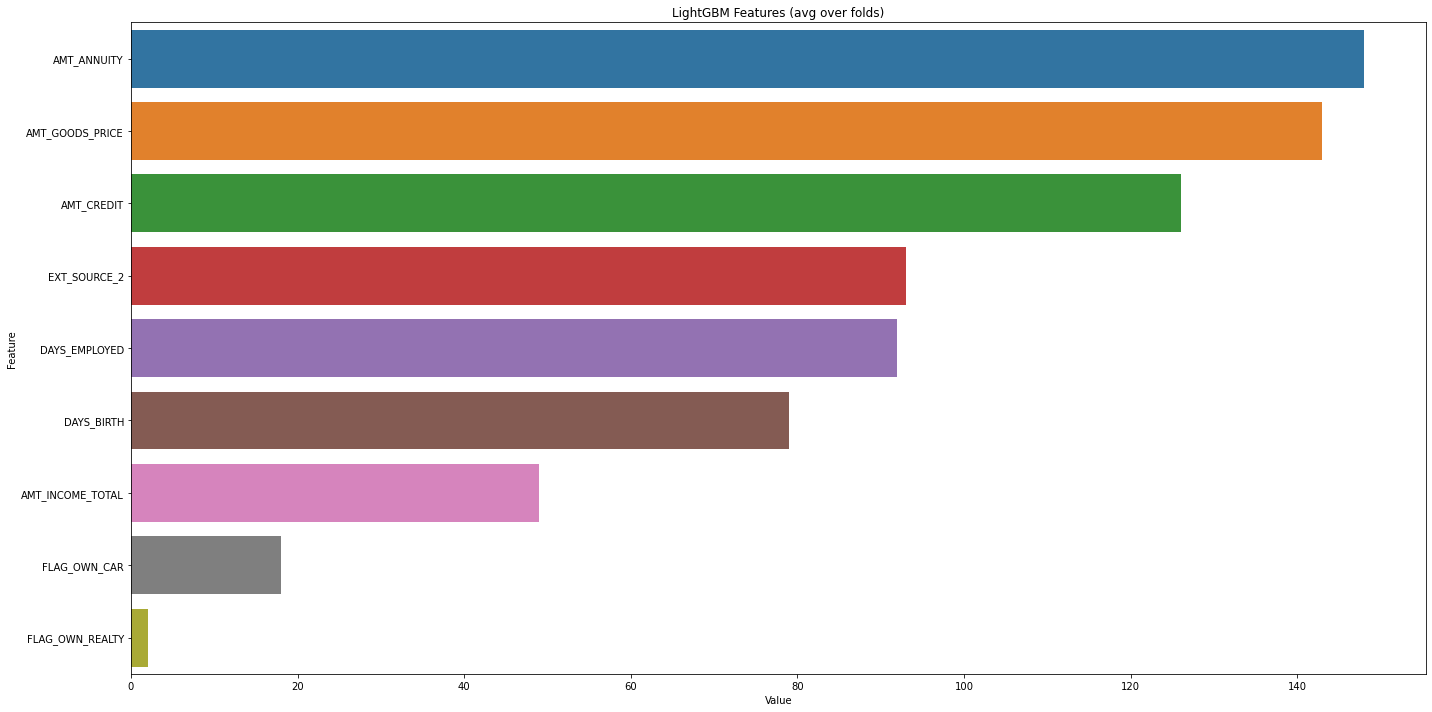

In [84]:
import seaborn as sns

boost_model = LGBMClassifier(random_state=2020, n_estimators=25, max_depth=7, learning_rate=0.2)
boost_model.fit(X_train[features], y_train)

# sorted(zip(clf.feature_importances_, X.columns), reverse=True)
feature_imp = pd.DataFrame(sorted(zip(boost_model.feature_importances_,features)),
                           columns=['Value','Feature'])

plt.figure(figsize=(20, 10))
sns.barplot(x="Value", y="Feature", data=feature_imp.sort_values(by="Value", ascending=False))
plt.title('LightGBM Features (avg over folds)')
plt.tight_layout()
plt.show()
#plt.savefig('lgbm_importances-01.png')

Самыми важными оказались признаки AMT_ANNUITY, AMT_GOODS_PRICE и AMT_CREDIT. Это немного неожиданно, так как параметр EXT_SOURCE_2 предположительно должен был оказать наибольшее влияние